In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer, mapper

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies

In [5]:
save_images = False

In [6]:
from narrative import nar181026_heat_confidence_genes

In [7]:
from random import shuffle
from scipy.stats import spearmanr

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['de_unit']=='both') & 
    (all_de['gene_ncbi'].isin(ref_genes))

]

In [10]:
all_de.loc[:, 'significant'] = all_de.loc[:, 'padj'] < 0.05

In [11]:
in_folder = '190406_predict_fold_change_mouse'

In [12]:
agg = []

for condition in all_de['condition'].unique():


    for b in range(0, 10):
        p = export.get_material_path(
            '{}/values_{}_{}.csv'.format(in_folder, condition, b))
        if os.path.exists(p):
            d = pd.read_csv(p)
            d.loc[:, 'condition'] = condition
            agg.append(d)


In [13]:
g = pd.concat(agg).groupby(['condition', 'gene_ncbi']).agg(np.median).reset_index()

In [14]:
g = pd.merge(
    g,
    all_de[['condition', 'gene_ncbi', 'significant', 'tissue', 'older']]

)

In [15]:
g.head()

,condition,gene_ncbi,predicted,boot,observed,significant,tissue,older
0,Adrenal_0_4_12,11287.0,2.938669,2.0,7.218219,True,Adrenal,12.0
1,Adrenal_0_4_12,11298.0,-0.093143,1.0,2.634682,False,Adrenal,12.0
2,Adrenal_0_4_12,11305.0,0.014981,8.0,-0.069880,False,Adrenal,12.0
3,Adrenal_0_4_12,11306.0,0.072680,9.0,0.282119,False,Adrenal,12.0
4,Adrenal_0_4_12,11307.0,-0.063493,4.0,0.184450,False,Adrenal,12.0


In [16]:
ages = [9, 12, 18, 24]

In [17]:
tissues = g['tissue'].unique()

In [18]:
out = pd.DataFrame(index=tissues, columns=ages)

In [19]:
for tissue in tissues:
    for age in ages:

        gg = g[
            (g['older']==age) &
            (g['tissue']==tissue)]

        
        out.loc[tissue, age] = spearmanr(gg['predicted'], gg['observed'])[1]


In [20]:
out.astype(float).apply(lambda x: np.log10(x))

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,9,12,18,24
Adrenal,-53.552555,-168.058887,-102.028317,-144.207662
BAT,-19.523603,-66.624338,-36.542814,-200.315791
Blood,-6.834598,-10.178614,-56.496420,-123.847060
Brain,-8.536793,-73.379648,-52.138431,-110.515801
Cerebellum,-inf,-19.671349,-15.429992,-47.262808
Esophagus,-106.987791,-162.886263,-51.156311,-88.167152
GutEP,-4.627002,-20.486501,-29.078938,-66.809768
Heart,-177.045090,-59.963502,-138.605486,-181.040422
Kidney,-inf,-133.066536,-142.970287,-inf
LI,-40.928721,-198.921147,-inf,-inf


In [21]:
o = out.astype(float).apply(lambda x: -np.log10(x))

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
o

,9,12,18,24
Adrenal,53.552555,168.058887,102.028317,144.207662
BAT,19.523603,66.624338,36.542814,200.315791
Blood,6.834598,10.178614,56.496420,123.847060
Brain,8.536793,73.379648,52.138431,110.515801
Cerebellum,inf,19.671349,15.429992,47.262808
Esophagus,106.987791,162.886263,51.156311,88.167152
GutEP,4.627002,20.486501,29.078938,66.809768
Heart,177.045090,59.963502,138.605486,181.040422
Kidney,inf,133.066536,142.970287,inf
LI,40.928721,198.921147,inf,inf


In [23]:
orig = o.copy()

In [24]:
maxv = 100

f = o> maxv
o[f] = maxv

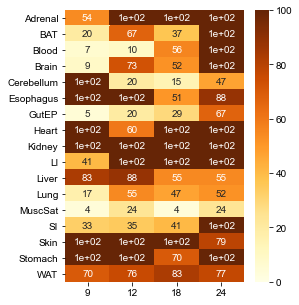

In [25]:
plt.figure(figsize=(4, 5))



sns.heatmap(
    o.apply(lambda x: np.round(x, 0)),
    cmap='YlOrBr', 
    annot=True,
    vmax=100,
    vmin=0
)


if save_images:
    export.export_image(
        '190411_accuracy_of_predictions/pval_prediction.pdf')

In [26]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr',
        vmin=0,
        vmax=100,
        annot=True)

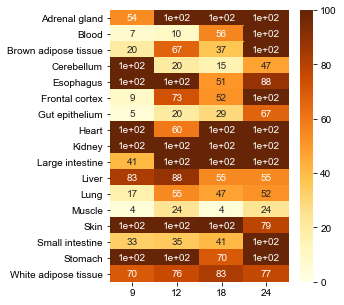

In [27]:
nice_plot(o.apply(lambda x: np.round(x, 0)))


if save_images:
    export.export_image(
        '190411_accuracy_of_predictions/pval_prediction_nice.pdf')

In [28]:
tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }

In [29]:
orig.rename(index=tissue_dict).sort_index()

,9,12,18,24
Adrenal gland,53.552555,168.058887,102.028317,144.207662
Blood,6.834598,10.178614,56.496420,123.847060
Brown adipose tissue,19.523603,66.624338,36.542814,200.315791
Cerebellum,inf,19.671349,15.429992,47.262808
Esophagus,106.987791,162.886263,51.156311,88.167152
Frontal cortex,8.536793,73.379648,52.138431,110.515801
Gut epithelium,4.627002,20.486501,29.078938,66.809768
Heart,177.045090,59.963502,138.605486,181.040422
Kidney,inf,133.066536,142.970287,inf
Large intestine,40.928721,198.921147,inf,inf
